In [4]:
import sys
sys.executable


'/Users/clarissamaheswari/Documents/Thesis/JOBBBB/Glints/.venv/bin/python'

=== Gender ===
sex
Female    177
Male      133
Name: count, dtype: int64

=== Marital Status ===
maritaldesc
Single       137
Married      123
Divorced      30
Separated     12
Widowed        8
Name: count, dtype: int64

=== Citizenship ===
citizendesc
US Citizen             294
Eligible NonCitizen     12
Non-Citizen              4
Name: count, dtype: int64

=== Race / Ethnicity ===
racedesc
White                               193
Black or African American            57
Asian                                34
Two or more races                    18
Hispanic                              4
American Indian or Alaska Native      4
Name: count, dtype: int64

=== State ===
state
MA    275
CT      6
TX      3
VT      2
AL      1
RI      1
ME      1
AZ      1
OR      1
MT      1
ND      1
KY      1
NC      1
FL      1
GA      1
CO      1
UT      1
NV      1
TN      1
ID      1
IN      1
OH      1
NY      1
NH      1
WA      1
CA      1
VA      1
PA      1
Name: count, dtype: int64

=== Pay Rat

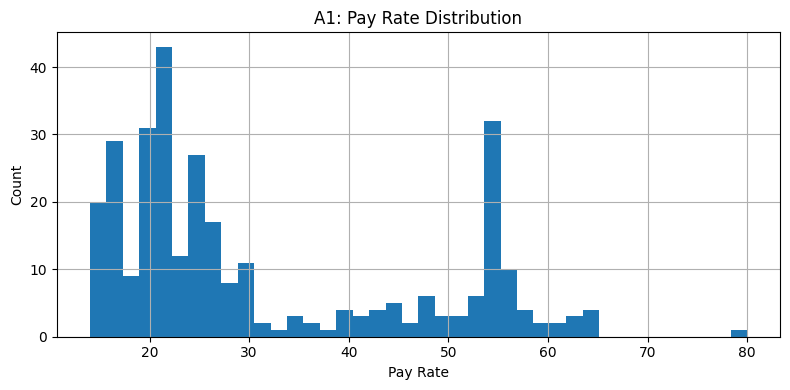

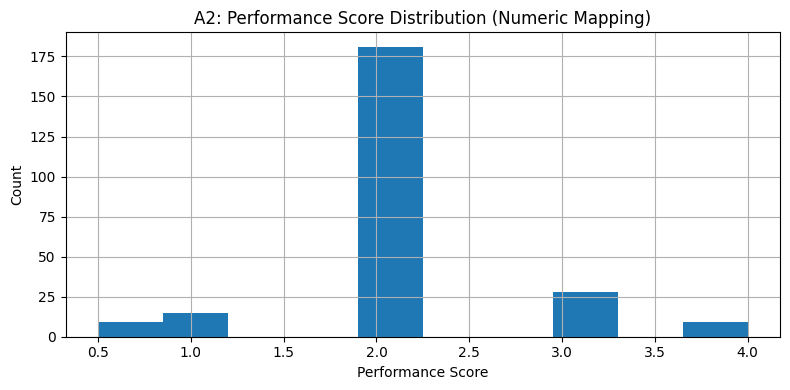

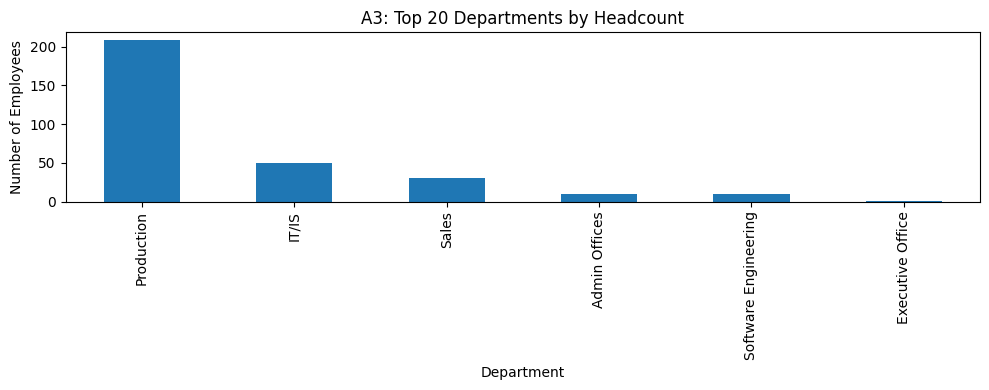

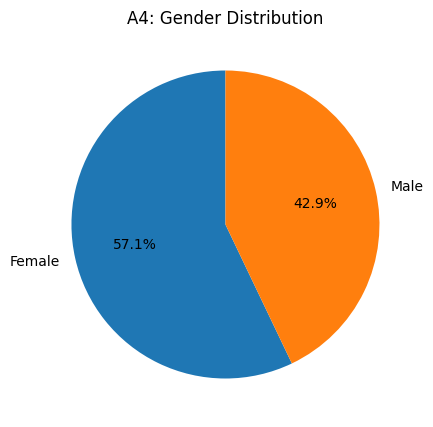

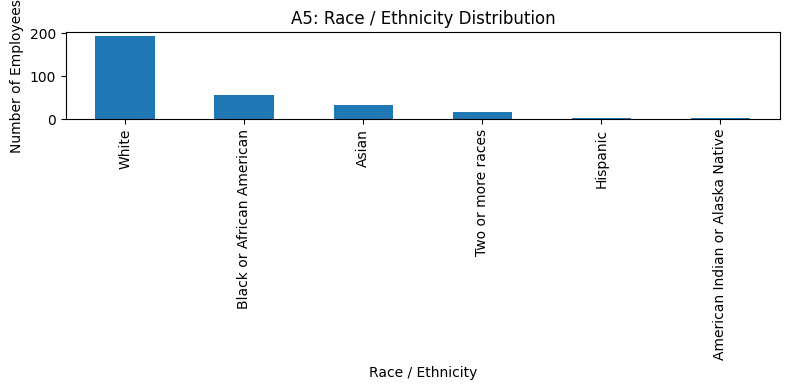

OSError: [Errno 30] Read-only file system: '/A5_race.png'

<Figure size 640x480 with 0 Axes>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

staff = pd.read_csv("output/staff_particulars.csv", dtype=str)

def clean_colnames(df):
    df.columns = [c.strip().replace(' ', '_').replace('/', '_').lower() for c in df.columns]
    return df
staff = clean_colnames(staff)

for col in ['dob','date_of_hire','date_of_termination']:
    if col in staff.columns:
        staff[col] = pd.to_datetime(staff[col], errors='coerce')

staff['pay_rate'] = pd.to_numeric(staff.get('pay_rate'), errors='coerce')

def parse_perf(x):
    if pd.isna(x): return np.nan
    xstr = str(x).strip().lower()
    try:
        return float(xstr)
    except:
        pass
    if 'exceptional' in xstr: return 4.0
    if 'exceed' in xstr: return 3.0
    if 'fully meet' in xstr: return 2.0
    if 'needs improv' in xstr: return 1.0
    if 'pip' in xstr: return 0.5
    return np.nan

staff['performance_score_num'] = staff['performance_score'].apply(parse_perf)

today = pd.Timestamp("2025-10-25")  # analysis date
staff['tenure_days'] = (today - staff['date_of_hire']).dt.days
staff['tenure_years'] = staff['tenure_days'] / 365.25

print("=== Gender ===")
print(staff['sex'].value_counts(dropna=False))
print("\n=== Marital Status ===")
print(staff['maritaldesc'].value_counts(dropna=False))
print("\n=== Citizenship ===")
print(staff['citizendesc'].value_counts(dropna=False))
print("\n=== Race / Ethnicity ===")
print(staff['racedesc'].value_counts(dropna=False))
print("\n=== State ===")
print(staff['state'].value_counts(dropna=False))

print("\n=== Pay Rate Stats ===")
print(staff['pay_rate'].describe())

# A1: Pay Rate Distribution
plt.figure(figsize=(8,4))
staff['pay_rate'].dropna().astype(float).hist(bins=40)
plt.title('A1: Pay Rate Distribution')
plt.xlabel('Pay Rate'); plt.ylabel('Count')
plt.tight_layout()
plt.show()

# A2: Performance Score Distribution
plt.figure(figsize=(8,4))
staff['performance_score_num'].dropna().hist(bins=10)
plt.title('A2: Performance Score Distribution (Numeric Mapping)')
plt.xlabel('Performance Score'); plt.ylabel('Count')
plt.tight_layout()
plt.show()

# A3: Top Departments by Headcount
if 'department' in staff.columns:
    plt.figure(figsize=(10,4))
    staff['department'].value_counts().head(20).plot(kind='bar')
    plt.title('A3: Top 20 Departments by Headcount')
    plt.xlabel('Department'); plt.ylabel('Number of Employees')
    plt.tight_layout()
    plt.show()

# A4: Gender Distribution (Pie Chart)
if 'sex' in staff.columns:
    plt.figure(figsize=(5,5))
    staff['sex'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title('A4: Gender Distribution')
    plt.ylabel('')
    plt.show()



# A5: Race / Ethnicity Distribution (Bar Chart)
if 'racedesc' in staff.columns:
    plt.figure(figsize=(8,4))
    staff['racedesc'].value_counts().plot(kind='bar')
    plt.title('A5: Race / Ethnicity Distribution')
    plt.xlabel('Race / Ethnicity'); plt.ylabel('Number of Employees')
    plt.tight_layout()
    plt.show()
    plt.savefig('/A5_race.png')


print("\nTOTAL EMPLOYEES:", len(staff))
print(f"Average Pay Rate: {staff['pay_rate'].mean():.2f}")
print(f"Median Pay Rate: {staff['pay_rate'].median():.2f}")
print(f"Average Tenure (Years): {staff['tenure_years'].mean():.1f}")
print(f"Performance Mean Score: {staff['performance_score_num'].mean():.2f}")


In [8]:
staff.groupby('department')['pay_rate'].mean().sort_values()

department
Production              23.086298
Admin Offices           31.896000
IT/IS                   45.789600
Software Engineering    48.665000
Sales                   55.524194
Executive Office        80.000000
Name: pay_rate, dtype: float64

In [16]:
import pandas as pd
import numpy as np
import os
import hashlib
from scipy.stats import zscore

os.makedirs("output", exist_ok=True)

def clean_colnames(df):
    df.columns = [c.strip().replace(" ", "_").replace("/", "_").lower() for c in df.columns]
    return df

def make_hash_id(x, prefix="id"):
    if pd.isna(x): 
        return None
    s = str(x).strip().lower().encode("utf-8")
    h = hashlib.sha1(s).hexdigest()[:8]
    return f"{prefix}_{h}"

# Load data
staff = pd.read_csv("output/staff_particulars.csv", dtype=str)
salary = pd.read_csv("output/salary_grid.csv", header=0, dtype=str)
recruit = pd.read_csv("output/recruitment_costs.csv", dtype=str)

staff = clean_colnames(staff)
salary = clean_colnames(salary)
recruit = clean_colnames(recruit)

# Parse dates
for col in ["dob", "date_of_hire", "date_of_termination"]:
    if col in staff.columns:
        staff[col] = pd.to_datetime(staff[col], errors="coerce")

# Ensure employee_id exists; prefer existing employee_number
if "employee_number" in staff.columns:
    staff["employee_id"] = staff["employee_number"].astype(str)
else:
    staff["employee_id"] = ["emp_" + str(i+1).zfill(6) for i in range(len(staff))]

# Manager ID
if "manager_name" in staff.columns:
    staff["manager_id"] = staff["manager_name"].apply(lambda x: make_hash_id(x, prefix="mgr") if pd.notna(x) else None)
else:
    staff["manager_name"] = np.nan
    staff["manager_id"] = None

# Source ID
if "employee_source" in staff.columns:
    staff["source_id"] = staff["employee_source"].apply(lambda x: make_hash_id(x, prefix="src") if pd.notna(x) else None)
else:
    staff["employee_source"] = np.nan
    staff["source_id"] = None

# Department ID
if "department" in staff.columns:
    staff["department_id"] = staff["department"].apply(lambda x: make_hash_id(x, prefix="dept") if pd.notna(x) else None)
else:
    staff["department"] = np.nan
    staff["department_id"] = None

# Numeric conversions
staff["pay_rate_num"] = pd.to_numeric(staff.get("pay_rate"), errors="coerce")

# Performance mapping
perf_map = {
    "exceptional": 4.0,
    "exceeds": 3.0,
    "fully meets": 2.0,
    "90-day meets": 2.0,
    "n/a- too early to review": np.nan,
    "needs improvement": 1.0,
    "pip": 0.5
}

def parse_perf(x):
    if pd.isna(x): return np.nan
    xstr = str(x).lower().strip()
    if xstr in perf_map: return perf_map[xstr]
    try:
        return float(xstr)
    except:
        pass
    if "exceptional" in xstr: return 4.0
    if "exceed" in xstr: return 3.0
    if "fully meet" in xstr: return 2.0
    if "needs improv" in xstr: return 1.0
    if "pip" in xstr: return 0.5
    return np.nan

staff["performance_score_num"] = staff["performance_score"].apply(parse_perf)

# Tenure calculation
today = pd.Timestamp("2025-10-25")
staff["tenure_days"] = (today - staff["date_of_hire"]).dt.days
staff["tenure_years"] = staff["tenure_days"] / 365.25

# Save cleaned staff with IDs for audit
staff.to_csv("output/staff_clean_with_ids.csv", index=False)

# 1. Recruitment Source Summary (with source_id)
src_summary = staff.groupby(["employee_source","source_id"], dropna=False).agg(
    n_hires=("employee_id","count"),
    avg_perf=("performance_score_num","mean"),
    median_tenure_years=("tenure_years","median"),
    avg_pay=("pay_rate_num","mean"),
    left_count=("date_of_termination", lambda s: s.notna().sum())
).reset_index()

src_summary["retention_rate"] = 1 - (src_summary["left_count"] / src_summary["n_hires"])
src_summary["retention_weighted_index"] = (0.4 * src_summary["avg_perf"].fillna(0) + 0.6 * src_summary["retention_rate"].fillna(0))
src_summary = src_summary.sort_values("retention_weighted_index", ascending=False)
src_summary.to_csv("output/recruitment_source_summary.csv", index=False)

# 2. Manager Summary (with manager_id + MEI)
mgr = staff.groupby(["manager_name","manager_id"], dropna=False).agg(
    team_size=("employee_id","count"),
    avg_perf=("performance_score_num","mean"),
    median_tenure_years=("tenure_years","median"),
    avg_pay=("pay_rate_num","mean"),
    left_count=("date_of_termination", lambda s: s.notna().sum())
).reset_index()

mgr["retention_rate"] = 1 - (mgr["left_count"] / mgr["team_size"])

# Z-score normalization (safe)
for col in ["avg_perf","retention_rate","median_tenure_years"]:
    if mgr[col].isnull().all() or mgr[col].std(ddof=0) == 0:
        mgr[col + "_z"] = 0
    else:
        mgr[col + "_z"] = zscore(mgr[col].fillna(mgr[col].mean()))

mgr["mei"] = mgr[["avg_perf_z","retention_rate_z","median_tenure_years_z"]].mean(axis=1)
mgr = mgr.sort_values("mei", ascending=False)
mgr.to_csv("output/manager_summary.csv", index=False)

# 3. Turnover by Department (with department_id)
if "department" in staff.columns:
    dept = staff.groupby(["department","department_id"], dropna=False).agg(
        headcount=("employee_id","count"),
        left_count=("date_of_termination", lambda s: s.notna().sum()),
        avg_tenure=("tenure_years","mean"),
        avg_pay=("pay_rate_num","mean")
    ).reset_index()
    dept["turnover_rate"] = dept["left_count"] / dept["headcount"]
    dept = dept.sort_values("turnover_rate", ascending=False)
    dept.to_csv("output/turnover_by_dept.csv", index=False)
else:
    print("Column 'department' not found — turnover_by_dept NOT generated.")

# 4. Salary grid top-5 (normalize salary cols and save sample)
if 'salary_min' in salary.columns or 'salary_max' in salary.columns or 'salary' in salary.columns:
    # try to coerce numeric salary column
    salary_cols = [c for c in salary.columns if 'salary' in c or 'pay' in c]
    for c in salary_cols:
        salary[c + "_num"] = pd.to_numeric(salary[c], errors='coerce')
    # pick best numeric column
    num_cols = [c for c in salary_cols if salary[c + "_num"].dtype.kind in 'fi']
    if num_cols:
        sort_col = num_cols[0] + "_num"
        salary = salary.sort_values(by=sort_col, ascending=False)
    salary.to_csv("output/salary_grid_processed.csv", index=False)
    salary.head(5).to_csv("output/salary_grid_top5.csv", index=False)
else:
    salary.to_csv("output/salary_grid_processed.csv", index=False)

print("Outputs written to output/ (recruitment_source_summary.csv, manager_summary.csv, turnover_by_dept.csv, staff_clean_with_ids.csv, salary_grid_top5.csv)")

Outputs written to output/ (recruitment_source_summary.csv, manager_summary.csv, turnover_by_dept.csv, staff_clean_with_ids.csv, salary_grid_top5.csv)


In [15]:
import os
os.makedirs("output", exist_ok=True)

staff['date_of_termination'] = pd.to_datetime(staff.get('date_of_termination'), errors='coerce')
staff['pay_rate_num'] = pd.to_numeric(staff.get('pay_rate'), errors='coerce')

# turnover by department
if 'department' in staff.columns:
    dept = staff.groupby('department').agg(
        headcount = ('employee_number','count'),
        left_count = ('date_of_termination', lambda s: s.notna().sum()),
        avg_tenure = ('tenure_years','mean'),
        avg_pay = ('pay_rate_num','mean')
    ).reset_index()
    dept['turnover_rate'] = dept['left_count'] / dept['headcount']
    # sort for convenience
    dept = dept.sort_values('turnover_rate', ascending=False)
    # save to output folder expected by streamlit
    dept.to_csv("output/turnover_by_dept.csv", index=False)
    print("Saved output/turnover_by_dept.csv")
else:
    print("Column 'department' not found - cannot compute turnover_by_dept")


Saved output/turnover_by_dept.csv


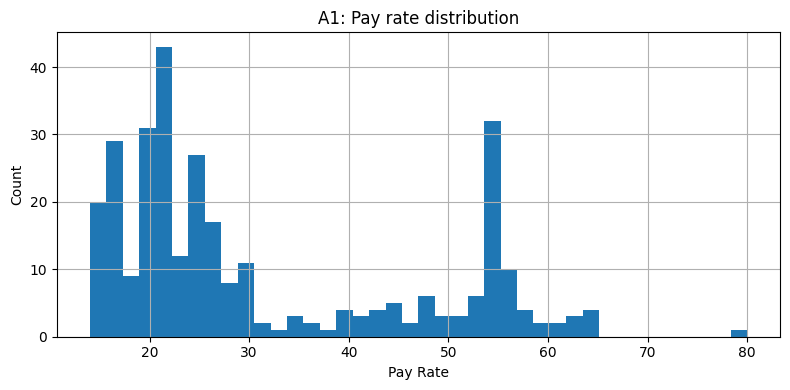

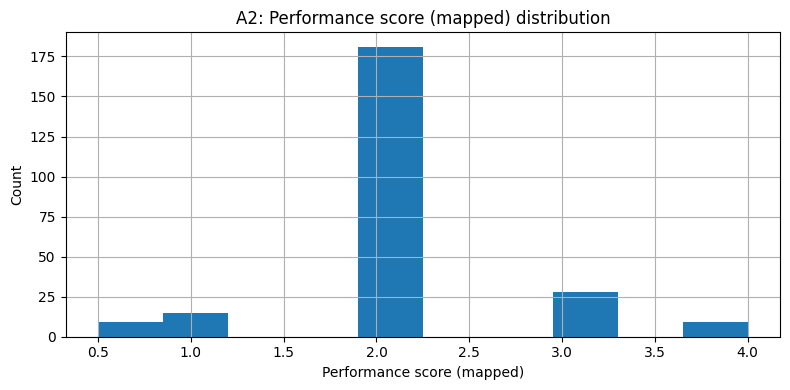

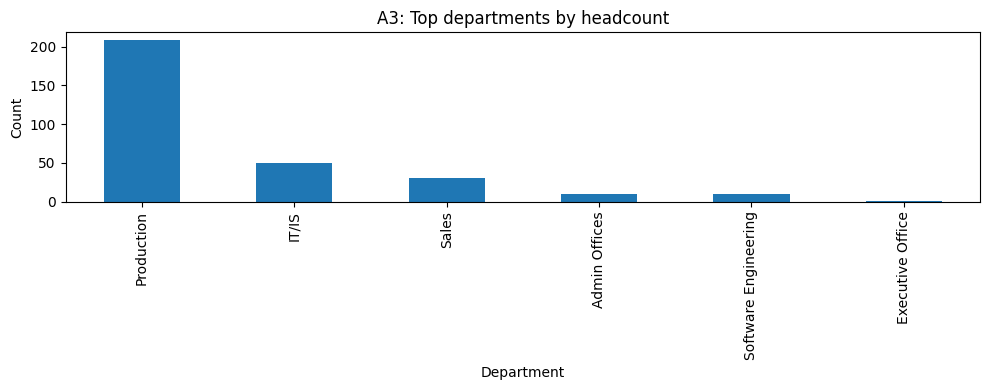

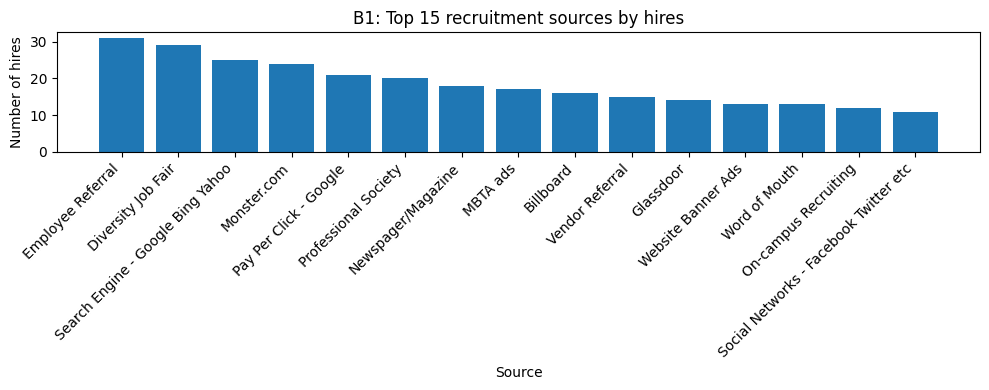

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


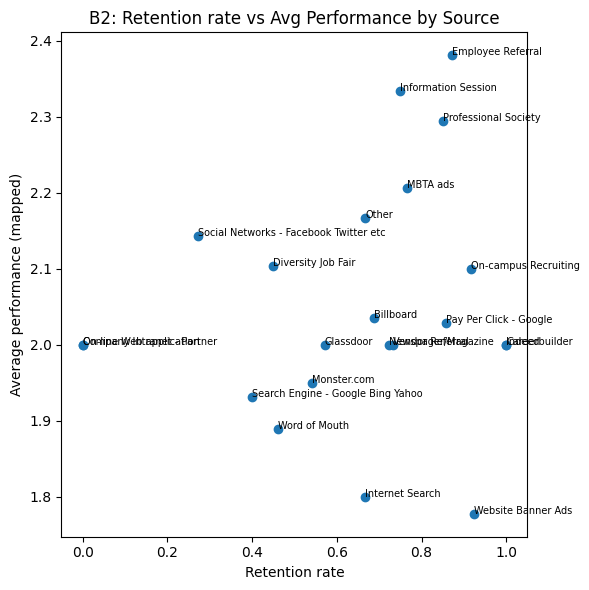

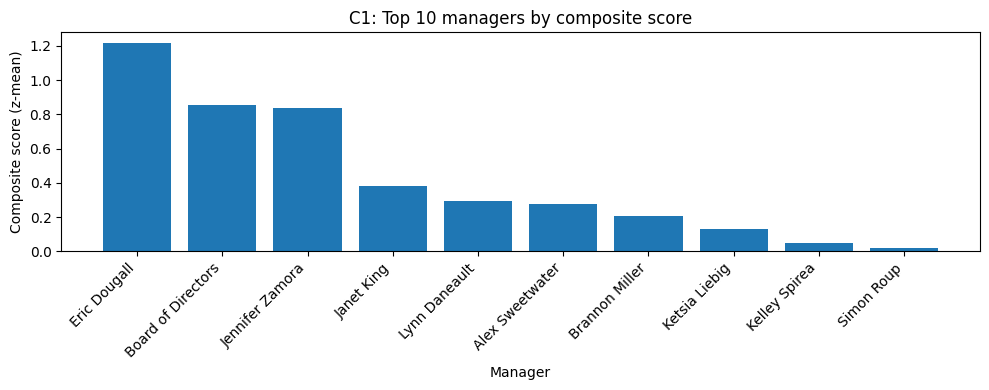

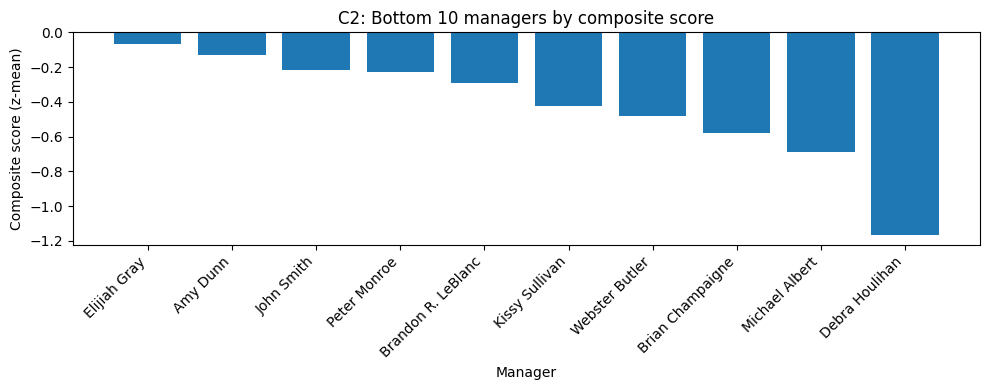

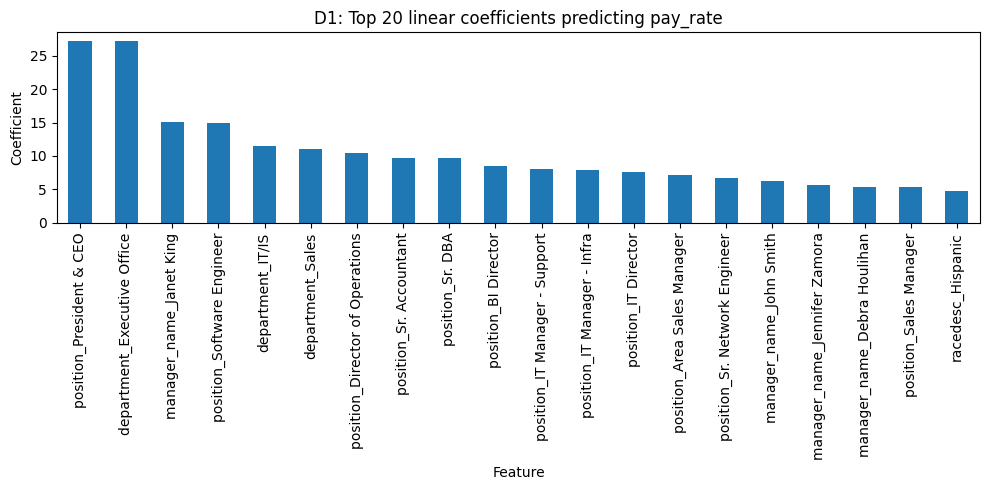

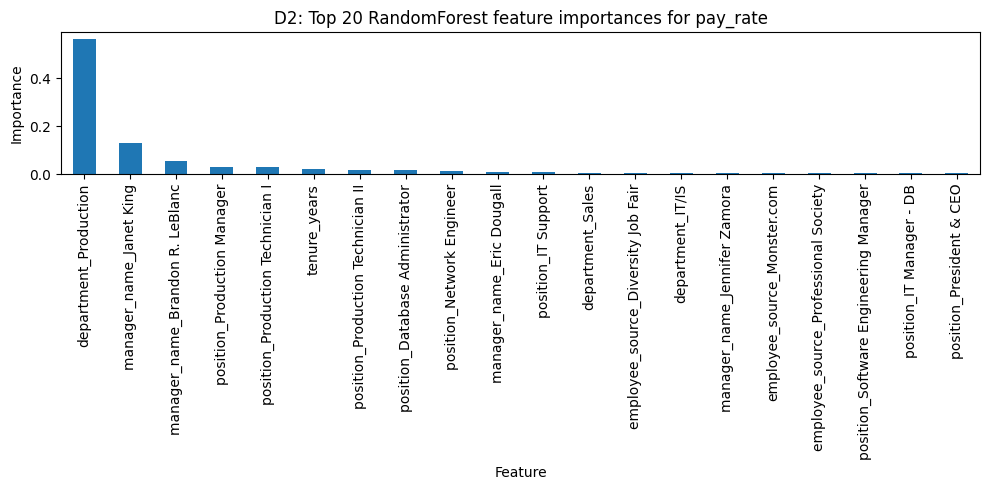

Charts saved to  as PNG files:
['/chart_a1_pay_hist.png', '/chart_a2_perf_hist.png', '/chart_a3_depts.png', '/chart_b1_top_sources.png', '/chart_b2_retention_perf.png', '/chart_c1_top_managers.png', '/chart_c2_bottom_managers.png', '/chart_d1_lin_coefs.png', '/chart_d2_rf_importances.png']


In [14]:
# Generating separate charts for parts a, b, c, d.
# Each section saves its charts to  and displays them.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy.stats import zscore

# Load cleaned data (reuse earlier cleaning steps)
staff = pd.read_csv("output/staff_particulars.csv", dtype=str)
def clean_colnames(df):
    df.columns = [c.strip().replace(' ', '_').replace('/', '_').lower() for c in df.columns]
    return df
staff = clean_colnames(staff)
for col in ['dob','date_of_hire','date_of_termination']:
    if col in staff.columns:
        staff[col] = pd.to_datetime(staff[col], errors='coerce')
staff['pay_rate'] = pd.to_numeric(staff.get('pay_rate'), errors='coerce')
# performance mapping function
def parse_perf(x):
    if pd.isna(x): return np.nan
    xstr = str(x).strip().lower()
    try:
        return float(xstr)
    except:
        pass
    if 'exceptional' in xstr: return 4.0
    if 'exceed' in xstr: return 3.0
    if 'fully meet' in xstr: return 2.0
    if 'needs improv' in xstr: return 1.0
    if 'pip' in xstr: return 0.5
    return np.nan
staff['performance_score_num'] = staff['performance_score'].apply(parse_perf)
today = pd.Timestamp("2025-10-25")
staff['tenure_days'] = (today - staff['date_of_hire']).dt.days
staff['tenure_years'] = staff['tenure_days']/365.25
staff['date_of_termination'] = pd.to_datetime(staff['date_of_termination'], errors='coerce')

# Part A: Exploratory charts
# Chart A1: Pay rate distribution histogram
plt.figure(figsize=(8,4))
staff['pay_rate'].dropna().astype(float).hist(bins=40)
plt.title('A1: Pay rate distribution')
plt.xlabel('Pay Rate'); plt.ylabel('Count')
plt.tight_layout()
plt.savefig('output/chart_a1_pay_hist.png')
plt.show()

# Chart A2: Performance score distribution histogram
plt.figure(figsize=(8,4))
staff['performance_score_num'].dropna().hist(bins=10)
plt.title('A2: Performance score (mapped) distribution')
plt.xlabel('Performance score (mapped)'); plt.ylabel('Count')
plt.tight_layout()
plt.savefig('output/chart_a2_perf_hist.png')
plt.show()

# Chart A3: Top departments by headcount
if 'department' in staff.columns:
    dept_counts = staff['department'].value_counts().head(20)
    plt.figure(figsize=(10,4))
    dept_counts.plot(kind='bar')
    plt.title('A3: Top departments by headcount')
    plt.xlabel('Department'); plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('output/chart_a3_depts.png')
    plt.show()

# Part B: Recruitment source analysis charts
if 'employee_source' in staff.columns:
    src = staff.groupby('employee_source').agg(
        n_hires=('employee_number','count'),
        avg_perf=('performance_score_num','mean'),
        left_count=('date_of_termination', lambda s: s.notna().sum())
    ).reset_index()
    src['retention_rate'] = 1 - src['left_count']/src['n_hires']
    src_sorted = src.sort_values('n_hires', ascending=False).head(15)
    # Chart B1: Top 15 sources by number of hires
    plt.figure(figsize=(10,4))
    plt.bar(src_sorted['employee_source'], src_sorted['n_hires'])
    plt.xticks(rotation=45, ha='right')
    plt.title('B1: Top 15 recruitment sources by hires')
    plt.xlabel('Source'); plt.ylabel('Number of hires')
    plt.tight_layout()
    plt.savefig('output/chart_b1_top_sources.png')
    plt.show()
    # Chart B2: Retention rate vs avg performance (scatter)
    plt.figure(figsize=(6,6))
    plt.scatter(src['retention_rate'], src['avg_perf'])
    for i,row in src.iterrows():
        plt.text(row['retention_rate'], row['avg_perf'], str(row['employee_source']), fontsize=7)
    plt.title('B2: Retention rate vs Avg Performance by Source')
    plt.xlabel('Retention rate'); plt.ylabel('Average performance (mapped)')
    plt.tight_layout()
    plt.savefig('output/chart_b2_retention_perf.png')
    plt.show()

# Part C: Manager analysis charts
if 'manager_name' in staff.columns:
    mgr = staff.groupby('manager_name').agg(
        team_size=('employee_number','count'),
        avg_perf=('performance_score_num','mean'),
        left_count=('date_of_termination', lambda s: s.notna().sum()),
        median_tenure_years=('tenure_years','median')
    ).reset_index()
    mgr['retention_rate'] = 1 - mgr['left_count']/mgr['team_size']
    # composite score z of avg_perf, retention_rate, median_tenure_years
    for col in ['avg_perf','retention_rate','median_tenure_years']:
        if mgr[col].std(ddof=0)==0:
            mgr[col+'_z']=0
        else:
            mgr[col+'_z']=zscore(mgr[col].fillna(mgr[col].mean()))
    mgr['composite_score'] = mgr[['avg_perf_z','retention_rate_z','median_tenure_years_z']].mean(axis=1)
    mgr_sorted = mgr.sort_values('composite_score', ascending=False)
    top10 = mgr_sorted.head(10)
    bottom10 = mgr_sorted.tail(10)
    # Chart C1: Top 10 managers by composite score (bar)
    plt.figure(figsize=(10,4))
    plt.bar(top10['manager_name'], top10['composite_score'])
    plt.xticks(rotation=45, ha='right')
    plt.title('C1: Top 10 managers by composite score')
    plt.xlabel('Manager'); plt.ylabel('Composite score (z-mean)')
    plt.tight_layout()
    plt.savefig('output/chart_c1_top_managers.png')
    plt.show()
    # Chart C2: Bottom 10 managers by composite score (bar)
    plt.figure(figsize=(10,4))
    plt.bar(bottom10['manager_name'], bottom10['composite_score'])
    plt.xticks(rotation=45, ha='right')
    plt.title('C2: Bottom 10 managers by composite score')
    plt.xlabel('Manager'); plt.ylabel('Composite score (z-mean)')
    plt.tight_layout()
    plt.savefig('output/chart_c2_bottom_managers.png')
    plt.show()

# Part D: Pay drivers charts
# Prepare features and run RF to get importances
pay_df = staff.dropna(subset=['pay_rate']).copy()
# select features
features = []
for f in ['position','department','tenure_years','performance_score_num','state','employee_source','manager_name','sex','racedesc']:
    if f in pay_df.columns:
        features.append(f)
# simple preprocessing
pay_df['performance_score_num'] = pay_df['performance_score_num'].fillna(pay_df['performance_score_num'].median())
pay_df['tenure_years'] = pay_df['tenure_years'].fillna(0)
pay_df['pay_rate_num'] = pd.to_numeric(pay_df['pay_rate'], errors='coerce').fillna(0)
X_pay = pd.get_dummies(pay_df[features], drop_first=True)
y_pay = pay_df['pay_rate_num'].astype(float)
# Linear regression
lr = LinearRegression().fit(X_pay, y_pay)
coefs = pd.Series(lr.coef_, index=X_pay.columns).sort_values(ascending=False).head(20)
# Chart D1: Top 20 linear coefficients (bar)
plt.figure(figsize=(10,5))
coefs.plot(kind='bar')
plt.title('D1: Top 20 linear coefficients predicting pay_rate')
plt.xlabel('Feature'); plt.ylabel('Coefficient')
plt.tight_layout()
plt.savefig('output/chart_d1_lin_coefs.png')
plt.show()

# Random Forest importances
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_pay, y_pay)
imp = pd.Series(rf.feature_importances_, index=X_pay.columns).sort_values(ascending=False).head(20)
plt.figure(figsize=(10,5))
imp.plot(kind='bar')
plt.title('D2: Top 20 RandomForest feature importances for pay_rate')
plt.xlabel('Feature'); plt.ylabel('Importance')
plt.tight_layout()
plt.savefig('output/chart_d2_rf_importances.png')
plt.show()

print("Charts saved to  as PNG files:")
print(["/chart_a1_pay_hist.png","/chart_a2_perf_hist.png","/chart_a3_depts.png",
       "/chart_b1_top_sources.png","/chart_b2_retention_perf.png",
       "/chart_c1_top_managers.png","/chart_c2_bottom_managers.png",
       "/chart_d1_lin_coefs.png","/chart_d2_rf_importances.png"])